# Tutorial 2: Simulated Data (Different Noise Levels and Combinations)

- **Purpose**: Evaluate the DCCAE module's capacity to capture the nonlinear correlations among omics;
- **Dataset**: Simulated dataset 2: Different Noise Levels and Combinations(https://doi.org/10.5281/zenodo.14854747).

## Loading package

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import scanpy as sc
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
import anndata as ad
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'
import sys
sys.path.append(r'D:/study/learning\spatial_transcriptome/papers\spatial_multi_omics-main')
from Model.utils import mclust_R
from Model.model import DCCAE
from Model.preprocess import fix_seed
fix_seed(2024)

In [2]:
def expand_anndata(adata):
    """
    Expand the original AnnData object to a new AnnData object.
    
    Parameters:
    adata (AnnData): The original AnnData object.
    
    Returns:
    AnnData: The expanded AnnData object.
    """

    # Get the data from other levels
    level_0_data = adata.uns['INR_level_0']
    level_1_data = adata.uns['INR_level_1']
    level_2_data = adata.uns['INR_level_2']
    level_3_data = adata.uns['INR_level_3']

    # Vertically stack the data
    new_X = np.vstack([level_0_data, level_1_data, level_2_data, level_3_data])

    # Create a new AnnData object
    new_adata = ad.AnnData(X=new_X)
    
    # Drop the 'batch' column from the original obs
    adata.obs = adata.obs.drop(columns=['batch'])
    
    # Create a 'noise' field for each part of the data
    noise_values = np.repeat([0, 1, 2, 3], adata.n_obs)
    
    # Copy the original obs data and expand it
    new_obs = pd.concat([adata.obs] * 4, ignore_index=True)
    new_obs['noise_level'] = noise_values

    new_adata.obs = new_obs
    new_adata.obsm['spatial'] = np.vstack([adata.obsm['spatial']] * 4)
    return new_adata

## Loading data

In [ ]:
replicate = 1
file_fold_1 = f'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Noise_Combination_{replicate}/Combination{replicate}_RNA'
file_fold_2 = f'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Noise_Combination_{replicate}/Combination{replicate}_Protein'

adata_omics_1 = sc.read_h5ad(file_fold_1 + '.h5ad')
adata_omics_2 = sc.read_h5ad(file_fold_2 + '.h5ad')

adata_omics_1 = expand_anndata(adata_omics_1)
adata_omics_2 = expand_anndata(adata_omics_2)

noise_level = 3
adata_omics_1 = adata_omics_1[adata_omics_1.obs['noise_level']==noise_level]
adata_omics_2 = adata_omics_2[adata_omics_2.obs['noise_level']==noise_level]

sc.pp.pca(adata_omics_1, use_highly_variable=False)
sc.pp.pca(adata_omics_2, use_highly_variable=False)

adata_RNA = adata_omics_1.copy()
adata_ADT = adata_omics_2.copy()

## Training the model

In [ ]:
n_DCCA = 5

features1 = adata_RNA.obsm['X_pca'].shape[1]  # Feature sizes
features2 = adata_ADT.obsm['X_pca'].shape[1]
layers1 = [256, 256, n_DCCA]  # nodes in each hidden layer and the output size
layers2 = [256, 256, n_DCCA]
X = adata_RNA.obsm['X_pca'].copy()
Y = adata_ADT.obsm['X_pca'].copy()

use_rep = ['DCCA_X', "DCCA_Y", "DCCA"]

epochs = 100
dcca = DCCAE(input_size1=features1, input_size2=features2, n_components=n_DCCA, layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=epochs, learning_rate=0.001)
dcca.fit([X, Y])
Xs_transformed = dcca.transform([X, Y])
adata_RNA.obsm["DCCA_X"] =  Xs_transformed[0]
adata_ADT.obsm["DCCA_Y"] =  Xs_transformed[1]
adata_RNA.obsm["DCCA"] = np.concatenate((adata_RNA.obsm["DCCA_X"], adata_ADT.obsm["DCCA_Y"]),axis=1)

n = 4

mclust_R(adata_RNA, used_obsm='DCCA_X', num_cluster=n)
obs_df = adata_RNA.obs.dropna()
ARI = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(f'n={n}, DCCA, ARI = {ARI}')

mclust_R(adata_ADT, used_obsm='DCCA_Y', num_cluster=n)
obs_df = adata_ADT.obs.dropna()
ARI = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(f'n={n}, DCCA, ARI = {ARI}')

mclust_R(adata_RNA, used_obsm='DCCA', num_cluster=n)
obs_df = adata_RNA.obs.dropna()
ARI = adjusted_rand_score(obs_df['clusters_mclust'], obs_df['Ground Truth'])
print(f'n={n}, DCCA, ARI = {ARI}')

Training Progress: 100%|██████████| 100/100 [00:06<00:00, 16.29it/s]

model training finished!
fitting ...
  |                                                                      |   0%

  |======================================================================| 100%
n=4, DCCA, ARI = 0.9176865006494802
fitting ...
  |======================================================================| 100%
n=4, DCCA, ARI = 0.7608546403066153
fitting ...
  |======================================================================| 100%
n=4, DCCA, ARI = 0.9136901477311118


## Storing the results

In [ ]:
adata_0 = ad.AnnData(obs=adata_RNA.obs[['clusters_mclust', 'noise_level']], obsm={'SpaKnit': adata_RNA.obsm['DCCA']})
adata_1 = ad.AnnData(obs=adata_RNA.obs[['clusters_mclust', 'noise_level']], obsm={'SpaKnit': adata_RNA.obsm['DCCA']})
adata_2 = ad.AnnData(obs=adata_RNA.obs[['clusters_mclust', 'noise_level']], obsm={'SpaKnit': adata_RNA.obsm['DCCA']})
adata_3 = ad.AnnData(obs=adata_RNA.obs[['clusters_mclust', 'noise_level']], obsm={'SpaKnit': adata_RNA.obsm['DCCA']})
adata_results = adata_0.concatenate(adata_1, adata_2, adata_3, batch_key='noise_level')

obs_df = adata_results.obs
obs_df = obs_df.rename(columns={'clusters_mclust': 'SpaKnit'})
adata_results.obs = obs_df

results = sc.read_h5ad(f'./Results/Noise_Combination_{replicate}.h5ad')
results.obs['SpaKnit'] = adata_results.obs['SpaKnit'].values
results.obsm['SpaKnit'] = adata_results.obsm['SpaKnit']
results.write_h5ad(f'./Results/Noise_Combination_{replicate}.h5ad')

AnnData object with n_obs × n_vars = 4800 × 0
    obs: 'Ground Truth', 'noise_level', 'SpaGCN', 'SpatialGlue', 'MultiMAP', 'STAGATE', 'Modality1', 'Modality2', 'SpaKnit'
    obsm: 'Modality1', 'Modality2', 'MultiMAP', 'STAGATE', 'SpatialGlue', 'spatial', 'SpaKnit'

## Visualizing results

In [2]:
replicate = 1
adata_analysis = sc.read_h5ad(f'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Noise_Combination_{replicate}.h5ad')

noise_level = 1   ## 0, 1, 2, 3
adata_analysis = adata_analysis[adata_analysis.obs['noise_level']==noise_level]

In [3]:
def reorder_categories(adata, method, new_order):
    """
    Reorder the categories of a given method in the AnnData object's.obs.
    
    Parameters:
    adata: AnnData object
    method: str, the name of the method to reorder
    new_order: list, the new order of categories
    """
    if not pd.api.types.is_categorical_dtype(adata.obs[method]):
        adata.obs[method] = pd.Categorical(adata.obs[method])
    adata.obs[method] = adata.obs[method].cat.reorder_categories(new_order)

new_orders = {
    'SpaKnit': [2, 1, 3, 4]
}

for method, new_order in new_orders.items():
    reorder_categories(adata_analysis, method, new_order)

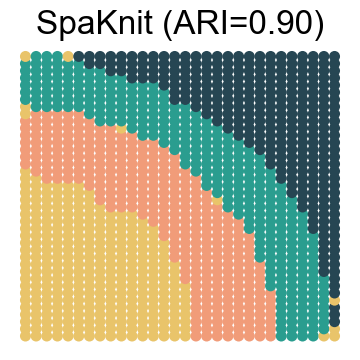

In [5]:
method = 'SpaKnit'

plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = ['Arial']

colors_domain = [
    '#f19c79', '#e9c46a', '#2a9d8f', '#264653'
]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# Calculate Adjusted Rand Index (ARI)
ari_value = adjusted_rand_score(adata_analysis.obs['Ground Truth'], adata_analysis.obs[method])
sc.pl.embedding(adata_analysis, basis='spatial', color=[method], title=None, s=250, colorbar_loc=None, show=False, ax=ax, palette=colors_domain, legend_loc=None)
# Set the title, including the ARI value
ax.set_title(f"{method} (ARI={ari_value:.2f})")
ax.set_xlabel('')
ax.set_ylabel('')

# Hide the borders of the axes
for spine in ax.spines.values():
    spine.set_visible(False)

# Adjust subplot parameters to reduce blank areas around the plot
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.tight_layout()

# Display the plot
plt.show()